$$
% transferring macros:
\let\eps\varepsilon
\let\wt\widetilde
\let\tn\mathrm
\let\vphi\varphi
\let\pa\partial
\let\para\parallel
\let\wh\widehat
\let\sl\shoveleft
% defining new macros:
\def\be{\begin{equation} \mskip 1cm}
\def\ee{\end{equation}}
\def\ba{\begin{align} \mskip 1cm}
\def\ea{\end{align}}
\def\RR{{\bf R}}
\def\grad{\tn{grad}\,}
\def\curl{\tn{curl}\,}
\def\div{\tn{div}\,}
\def\Im{\tn{Im}}
% defining new commands:
\newcommand{\abs}[1]{\lvert#1\rvert}
\newcommand{\bold}[1]{{\bf #1}}
\newcommand{\pder}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\dt}[1]{\frac{\mathrm d #1}{\mathrm dt}}
$$

# Basics of Lagrange finite elements 

In [1]:
import numpy as np
from scipy import integrate as integ
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import fembase as fem

In [2]:
degree = 1
# polynomial degree
lag = fem.LagrangeShape(np.linspace(-1, 1, degree + 1))
# check the docstring to see what this does

In [3]:
#fem.LagrangeShape?
print(lag.__doc__)

The class for 1D Lagrange shape functions on the interval [-1,1].
    
    Parameters: 
        pts : ndarray
            1D array of increasing values in [-1, 1] defining the Lagrange polynomials.   
                    
    Returns:
        self.kind : string
            Is set to 'lagrange'.
        self.d : int
            Polynomial degree.
        self.s : ndarray
            The input array pts.
        self.eta : list
            List elements are the shape functions in 'poly1d' format.
        self.Deta : list
            List elements are the derivatives of the shape functions in 'poly1d' format.  
        self.mass : ndarray
            Mass matrix.  
        self.stiff : ndarray
            Stiffness matrix.
    


In [4]:
print('kind =', lag.kind)
print('\nd =', lag.d)
print('\ns =', lag.s)
print('\neta =', lag.eta)
print('\nDeta =', lag.Deta)
print('\nmass =', lag.mass)
print('\nstiff =', lag.stiff)

kind = lagrange

d = 1

s = [-1.  1.]

eta = [poly1d([-0.5,  0.5]), poly1d([0.5, 0.5])]

Deta = [poly1d([-0.5]), poly1d([0.5])]

mass = [[0.66666667 0.33333333]
 [0.33333333 0.66666667]]

stiff = [[ 0.5 -0.5]
 [-0.5  0.5]]


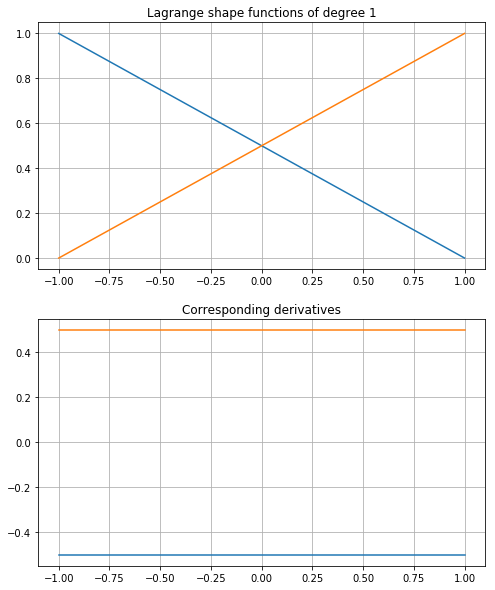

In [5]:
fig = plt.figure(figsize=(8, 10))
axes = fig.subplots(2, 1)
(ax1, ax2) = axes 

svec = np.linspace(-1,1,100)

for i in range(lag.d + 1):
    ax1.plot(svec, lag.eta[i](svec))
    ax2.plot(svec, lag.Deta[i](svec))
    
ax1.grid()
ax1.set(title='Lagrange shape functions of degree ' + str(lag.d))
ax2.grid()
ax2.set(title='Corresponding derivatives')

plt.show()

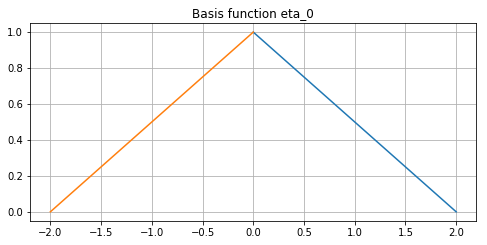

In [6]:
fig = plt.figure(figsize=(8, lag.d*6 + 2 ))
axes = fig.subplots(lag.d + 1, 1) 

for i in range(lag.d + 1):
    
    if i == lag.d:
        axes[0].plot(svec - lag.s[i], lag.eta[i](svec), color='C' + str(i))
    else:
        axes[i].plot(svec - lag.s[i], lag.eta[i](svec), color='C' + str(i))
        axes[i].grid()
        axes[i].set(title='Basis function eta_' + str(i))

fig.delaxes(axes[lag.d])
plt.show()

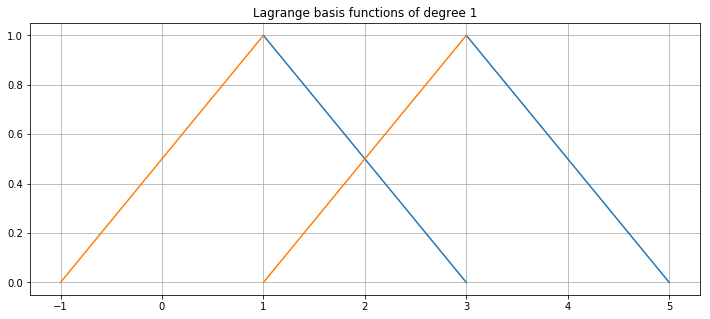

In [7]:
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots()

for i in range(lag.d + 1):
    
    if i == 0:
        ax.plot(svec + 2, lag.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 4, lag.eta[i](svec), color='C' + str(i))
    elif i == lag.d:
        ax.plot(svec, lag.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 2, lag.eta[i](svec), color='C' + str(i))
    else:
        ax.plot(svec, lag.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 2, lag.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 4, lag.eta[i](svec), color='C' + str(i))
    
    
ax.grid()
ax.set(title='Lagrange basis functions of degree ' + str(lag.d))

plt.show()

In [8]:
el_b = np.linspace(-np.pi, np.pi, 2**4 + 1)
# element boundaries (defining the simulation domain including the domain boundaries)
# can be any 1D array with strictly increasing entries
print('len(el_b) =', len(el_b))
print()
for i in range(len(el_b)):
    print('el_b({0}) = {1:3.2f}'.format(i, el_b[i]))

Nel = len(el_b) - 1
print('\nNel =', Nel)
# number of elements
deg = lag.d
# polynomial degree
NN = Nel*(deg + 1) - (Nel - 1)
N0 = NN - 2 
N1 = NN - 1
# number of degrees of freedom (NN including the boundary)
print('\nNN =', NN)

# mesh points

len(el_b) = 17

el_b(0) = -3.14
el_b(1) = -2.75
el_b(2) = -2.36
el_b(3) = -1.96
el_b(4) = -1.57
el_b(5) = -1.18
el_b(6) = -0.79
el_b(7) = -0.39
el_b(8) = 0.00
el_b(9) = 0.39
el_b(10) = 0.79
el_b(11) = 1.18
el_b(12) = 1.57
el_b(13) = 1.96
el_b(14) = 2.36
el_b(15) = 2.75
el_b(16) = 3.14

Nel = 16

NN = 17


In [9]:
# Mass matrix assembly:

mass0 = np.zeros((N0, N0))
print(mass0)
print()
# initiate mass matrix

# left boundary:
mass0[:lag.d, :lag.d] = (el_b[1] - el_b[0])/2*lag.mass[1:, 1:]
index = lag.d - 1
print('i =', 0)
print(mass0[:index + 1, :index + 1])
print()

# bulk:
for i in np.arange(1, Nel - 1):
    mass0[index:index + lag.d + 1, index:index + lag.d + 1] += (
        (el_b[i + 1] - el_b[i])/2*lag.mass[:, :] )
    index += lag.d
    # remark the '+=' in mass0 for the cumulative sum for overlapping degrees of freedom
    if i == 1:
        print('i =', i)
        print(mass0[:index + 1, :index + 1])
        print()
    elif i == Nel - 2:
        print('i =', i)
        print(mass0[index - lag.d:, index - lag.d:])
        print()
    
# right boundary
mass0[index:index + lag.d, index:index + lag.d] += (
        (el_b[-1] - el_b[-2])/2*lag.mass[:-1, :-1] )
print('i =', Nel - 1)
print(mass0[index - lag.d:, index - lag.d:])
print()

print(mass0)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

i = 0
[[0.13089969]]

i = 1
[[0.26179939 0.06544985]
 [0.06544985 0.13089969]]

i = 14
[[0.26179939 0.06544985]
 [0.06544985 0.13089969]]

i = 15
[[0.26179939 0.06544985]
 [0.06544985 0.26179939]]

[[0.26179939 0.06544985 0.         0.         0.         0.
  0.         0.     

In [10]:
# Stiffness matrix assembly:

stiff0 = np.zeros((N0, N0))
# initiate stiffness matrix

# left boundary:
stiff0[:lag.d, :lag.d] = 2/(el_b[1] - el_b[0])*lag.stiff[1:, 1:]
index = lag.d - 1

# bulk:
for i in np.arange(1, Nel - 1):
    stiff0[index:index + lag.d + 1, index:index + lag.d + 1] += (
        2/(el_b[i + 1] - el_b[i])*lag.stiff[:, :] )
    index += lag.d
    
# right boundary
stiff0[index:index + lag.d, index:index + lag.d] += (
        2/(el_b[-1] - el_b[-2])*lag.stiff[:-1, :-1] )

We want to test our implementation of the mass and stiffness matrices. In order to verify the mass matrix we test the $L^2$-projection. Let $E\in L^2((a,b))$ and denote by $\Lambda^2_0: L^2 \to V_0$ the $L^2$-projection on the finite dimensional subspace spanned by the basis functions $(\varphi_j^0)_{1 \leq j \leq N_0}$. The $L^2$-projection is defined by

$$
\be \label{L2proj}
 ( \Lambda^2_0 E - E,\, \varphi_j^0 )_{L^2} = 0 \qquad \forall\,\varphi_j^0\,.
\ee
$$

At the same time, we have

$$
\be
 (\Lambda^2_0 E)(x) = \sum_{i=1}^{N_0} e_i\,\varphi_i^0(x)\,,
\ee
$$

where $e = (e_i)_{1\leq i \leq N_0} \in \mathbb R^{N_0}$ holds the coefficients of the projected $E$ in the given basis. Moreover, we denote the mass matrix by $M^0 \in \mathbb R^{N_0 \times N_0}$ and define the vector $\overline E = (\overline E_j)_{1 \leq j \leq N_0} \in \mathbb R^{N_0}$ with $\overline E_j := (E,\,\varphi_j^0)_{L^2}$. With this, from \eqref{L2proj} we obtain

$$
\ba
 &( \Lambda^2_0 E,\, \varphi_j^0 )_{L^2} = ( E,\, \varphi_j^0 )_{L^2} \qquad \forall\,\varphi_j^0
 \\[1mm]
 &\Leftrightarrow\quad \sum_{i=1}^{N_0} e_i \int_a^b \varphi_i^0 \varphi_j^0\,\tn d x = \overline E_j \qquad \forall\,j   \nonumber
 \\[0mm]
 &\Leftrightarrow\quad \sum_{i=1}^{N_0} e_i \, M^0_{i,j} = \overline E_j \qquad \forall\,j  \nonumber
 \\[1mm]
 &\Leftrightarrow\quad (M^0)^\top \cdot e = \overline E   \nonumber
 \\[4mm]
 &\Leftrightarrow\quad e = (M^0)^{-1} \cdot \overline E \,.  \label{L2formula}
\ea
$$

To get to the last line we used that the mass matrix is symmetric. We shall compute the projection of a given function $E$ from formula \eqref{L2formula} and then compare $||\Lambda^2_0 E - E||_{L^2}$ for different degrees of polynomials and mesh resolution. For this we included the above assembly procedures as the function <i>fembase.lag_assemb</i> in the module _fembase.py_.

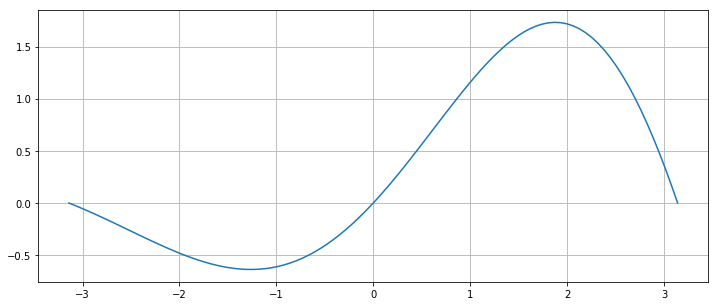

In [20]:
# The function we project:
Efun = lambda x: np.sin(x)*np.exp(x/np.pi)
xvec = np.linspace(-np.pi, np.pi, 100)
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots()
ax.plot(xvec, Efun(xvec))
ax.grid()

In [116]:
def L2prod_shape(fun, eta, el_b, bcs=2):
    '''Computes the L2 scalar product of a function with each element of a basis
    defined from shape functions.
    
    Parameters:
        fun : function
            The input function, for example a 'lambda'-function.
        eta : list
            List elements are the shape functions in 'poly1d' format.
        el_b : ndarray
            1D array of element interfaces from left to right including the boundaries. 
        bcs : int
            Specifies the boundary conditions. DEFAULT = 2 which stands for Dirichlet.
            1 stands for periodic.
            
    Returns:
        Nel : int
            The number of elements, Nel = len(el_b) - 1. 
        funbar : ndarray
            1D array of scalar products of fun with the basis functions.
        Nbase : int
            The number of basis functions, Nbase = np.size(fun_bar)
    '''
    
    from scipy.integrate import fixed_quad 
    
    Nel = len(el_b) - 1
    # number of elements
    
    m = len(eta)
    # number of shape functions
    
    d = m - 1
    # polynomial degree
    
    Ntot = Nel*m - (Nel - 1)
    Nbase = Ntot - bcs
    # number of basis functions
    
    funbar = np.zeros(Nbase)
    # initiate output vector
    
    index = 0
    # index of the basis function
    
    # left boundary:
    i = 0
    for j in np.arange(1, d):
            
        fun1 = lambda s: fun( el_b[i] + (s + 1)/2*(el_b[i + 1] - el_b[i]) )
        # function fun transformed to the reference element [-1, 1]
        fun2 = lambda s: np.polyval(eta[j], s)
        # shape function
        
        fun12 = lambda s: fun1(s)*fun2(s)
        intval, foo = fixed_quad(fun12, -1, 1)
        funbar[index] += (el_b[i + 1] - el_b[i])/2*intval
        # integral
        
        if j != d:
            index += 1
        # If it is the last shape function (j = d), the index rests the same
        # and the subsequent integral is added at the same position in funbar.
        
        print(j)
        print(index)
        print()
    
    # bulk:
    for i in np.arange(1, Nel - 1): 
        for j in range(m):
            
            fun1 = lambda s: fun( el_b[i] + (s + 1)/2*(el_b[i + 1] - el_b[i]) )
            # function fun transformed to the reference element [-1, 1]
            fun2 = lambda s: np.polyval(eta[j], s)
            # shape function
            
            fun12 = lambda s: fun1(s)*fun2(s)
            intval, foo = fixed_quad(fun12, -1, 1)
            funbar[index] += (el_b[i + 1] - el_b[i])/2*intval
            # integral
            if j != d:
                index += 1
            
        print(j)
        print(index)
        print()
        
    # right boundary:
    i = Nel - 1
    for j in range(d):
            
        fun1 = lambda s: fun( el_b[i] + (s + 1)/2*(el_b[i + 1] - el_b[i]) )
        # function fun transformed to the reference element [-1, 1]
        fun2 = lambda s: np.polyval(eta[j], s)
        # shape function
        
        fun12 = lambda s: fun1(s)*fun2(s)
        intval, foo = fixed_quad(fun12, -1, 1)
        funbar[index] += (el_b[i + 1] - el_b[i])/2*intval
        # integral
        
        print(j)
        print(index)
    
    return Nel, funbar, Nbase
    

In [117]:
a, b, c = L2prod_shape(Efun, lag.eta, el_b)
print(a)
print(b)
print(c)
print(len(b))
print(list(range(c)))

1
1

1
2

1
3

1
4

1
5

1
6

1
7

1
8

1
9

1
10

1
11

1
12

1
13

1
14

1
15

1
16

1
17

1
18

1
19

1
20

1
21

1
22

1
23

1
24

1
25

1
26

1
27

1
28

1
29

1
30

1
31

1
32

1
33

1
34

1
35

1
36

1
37

1
38

1
39

1
40

1
41

1
42

1
43

1
44

1
45

1
46

1
47

1
48

1
49

1
50

1
51

1
52

1
53

1
54

1
55

1
56

1
57

1
58

1
59

1
60

1
61

1
62

1
63

1
64

1
65

1
66

1
67

1
68

1
69

1
70

1
71

1
72

1
73

1
74

1
75

1
76

1
77

1
78

1
79

1
80

1
81

1
82

1
83

1
84

1
85

1
86

1
87

1
88

1
89

1
90

1
91

1
92

1
93

1
94

1
95

1
96

1
97

1
98

1
99

1
100

1
101

1
102

1
103

1
104

1
105

1
106

1
107

1
108

1
109

1
110

1
111

1
112

1
113

1
114

1
115

1
116

1
117

1
118

1
119

1
120

1
121

1
122

1
123

1
124

1
125

1
126

1
127

1
128

1
129

1
130

1
131

1
132

1
133

1
134

1
135

1
136

1
137

1
138

1
139

1
140

1
141

1
142

1
143

1
144

1
145

1
146

1
147

1
148

1
149

1
150

1
151

1
152

1
153

1
154

1
155

1
156

1
157

1
158

1


In [113]:
fixed_quad?

In [49]:
print(L2prod_shape.__doc__)

Computes the L2 scalar product of a function with each element of a basis
    defined from shape functions.
    
    Parameters:
        fun : function
            The input function, for example a 'lambda'-function.
        eta : list
            List elements are the shape functions in 'poly1d' format.
        el_b : ndarray
            1D array of element interfaces from left to right including the boundaries. 
            
    Returns:
        fun_bar : ndarray
            1D array of scalar products of fun with the basis functions.
    


In [24]:
# 1st degree polynomials
del lag 
lag = fem.LagrangeShape(np.linspace(-1, 1, 1 + 1))
# the object holding first order Lagrange shape functions

# loop over different number of elements (mesh resolution):
for i in range(3,9):
    
    del el_b, Nel, mass, stiff
    el_b = np.linspace(-np.pi, np.pi, 2**i + 1)
    Nel, mass, stiff = fem.lag_assemb(el_b, lag.mass, lag.stiff)
    print('Nel =', Nel)
    print('mass.shape =', mass.shape)

Nel = 8
mass.shape = (7, 7)
Nel = 16
mass.shape = (15, 15)
Nel = 32
mass.shape = (31, 31)
Nel = 64
mass.shape = (63, 63)
Nel = 128
mass.shape = (127, 127)
Nel = 256
mass.shape = (255, 255)
